## Task 3 Part c)

In [1]:
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import librosa
import librosa.display
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rishita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rishita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rishita\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
# Paths to data folders
ANTHEM_TEXT_DIR = r"C:\Users\Rishita\Desktop\MMDP-Assignment-change\Task3_a\anthem_translations"  # Folder containing anthem text files
RESULTS_DIR = r"C:\Users\Rishita\Desktop\MMDP-Assignment-change\Task3_c\results"  # Folder to save results

In [18]:
def load_anthem_texts():
    """Load all anthem text files into a dictionary."""
    anthem_texts = {}
    
    for files in os.listdir(ANTHEM_TEXT_DIR):
        country_name = files.replace('.txt', '')
        file_path = os.path.join(ANTHEM_TEXT_DIR, files)
        print("file path: ", file_path)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
                # Skip empty text files
                if text.strip():
                    anthem_texts[country_name] = text
                    print("Country Name: ", country_name)
                    print("Text: ", text)
                else:
                    print(f"Skipping {country_name}: empty text file")
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    
    print(f"Loaded {len(anthem_texts)} anthem text files.")
    return anthem_texts

def analyze_anthem_texts(anthem_texts):
    """Perform textual analysis on anthem texts."""
    print("\n--- TEXTUAL ANALYSIS ---")
    print("Anthem text: ", anthem_texts)
    
    # Check if there are any anthem texts to analyze
    if not anthem_texts:
        print("No anthem texts were found. Skipping textual analysis.")
        return {}, None, pd.DataFrame()
    
    # Preprocess texts
    processed_texts = {country: preprocess_text(text) for country, text in anthem_texts.items()}
    
    # Basic statistics
    text_lengths = {country: len(text.split()) for country, text in processed_texts.items()}
    
    # Check if there are any processed texts
    if not text_lengths:
        print("No texts remained after preprocessing. Skipping textual analysis.")
        return processed_texts, None, pd.DataFrame()
    
    avg_length = np.mean(list(text_lengths.values()))
    print(f"Average anthem length (after preprocessing): {avg_length:.2f} words")
    
    # Find shortest and longest anthems
    shortest = min(text_lengths.items(), key=lambda x: x[1])
    longest = max(text_lengths.items(), key=lambda x: x[1])
    print(f"Shortest anthem: {shortest[0]} ({shortest[1]} words)")
    print(f"Longest anthem: {longest[0]} ({longest[1]} words)")
    
    # Create a single corpus for overall analysis
    all_text = ' '.join(processed_texts.values())
    
    # Most common words across all anthems
    words = all_text.split()
    word_counts = Counter(words)
    print("\nMost common words across all anthems:")
    for word, count in word_counts.most_common(15):
        print(f"{word}: {count}")
    
    # Create word cloud for all anthems
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Common Words in National Anthems')
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(RESULTS_DIR, 'anthem_wordcloud.png'))
    
    # TF-IDF Analysis
    vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_matrix = vectorizer.fit_transform([text for text in processed_texts.values()])
    
    # Get feature names (words)
    feature_names = vectorizer.get_feature_names_out()
    
    # Create DataFrame for easier analysis
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), 
                           index=list(processed_texts.keys()),
                           columns=feature_names)
    
    # Save TF-IDF matrix
    tfidf_df.to_csv(os.path.join(RESULTS_DIR, 'anthem_tfidf.csv'))
    
    # Dimensionality reduction for visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(tfidf_matrix.toarray())
    
    # Clustering analysis
    num_clusters = min(5, len(processed_texts))  # Ensure we don't have more clusters than countries
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(tfidf_matrix)
    
    # Create a DataFrame with clustering results
    cluster_df = pd.DataFrame({
        'Country': list(processed_texts.keys()),
        'Cluster': clusters
    })
    
    # Print clusters with country names in different colors
    print("\nAnthem text clusters:")
    cluster_colors = ['red', 'blue', 'green', 'purple', 'orange']
    
    # Save clustering results
    cluster_df.to_csv(os.path.join(RESULTS_DIR, 'anthem_text_clusters.csv'), index=False)
    
    # Create a color-coded PCA plot
    plt.figure(figsize=(12, 8))
    
    # Dictionary to store countries by cluster for legend
    countries_by_cluster = {}
    
    # Plot each cluster with its own color
    for cluster_id in range(num_clusters):
        # Get countries in this cluster
        cluster_countries = cluster_df[cluster_df['Cluster'] == cluster_id]['Country'].tolist()
        countries_by_cluster[cluster_id] = cluster_countries
        
        # Get indices of these countries
        indices = [list(processed_texts.keys()).index(country) for country in cluster_countries]
        
        # Plot points for this cluster
        plt.scatter(
            pca_result[indices, 0], 
            pca_result[indices, 1], 
            color=cluster_colors[cluster_id % len(cluster_colors)],
            alpha=0.7,
            label=f'Cluster {cluster_id}'
        )
        
        # Add country names as annotations
        for idx, country in enumerate(cluster_countries):
            i = list(processed_texts.keys()).index(country)
            plt.annotate(country, (pca_result[i, 0], pca_result[i, 1]), 
                         fontsize=8, alpha=0.8, 
                         color=cluster_colors[cluster_id % len(cluster_colors)])
    
    # Print cluster information with colored text output to console
    for cluster_id in range(num_clusters):
        countries = countries_by_cluster[cluster_id]
        print(f"Cluster {cluster_id} ({cluster_colors[cluster_id % len(cluster_colors)]}): " + 
              f"{', '.join(countries[:5])}{'...' if len(countries) > 5 else ''}")
        # If you want to see all countries in each cluster, uncomment this
        # print(f"Full list: {', '.join(countries)}")
    
    plt.title('PCA of National Anthem Texts (Colored by Cluster)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(RESULTS_DIR, 'anthem_text_pca_clustered.png'))
    
    # Create a colored cluster map
    plt.figure(figsize=(14, 10))
    
    # Create a mapping of countries to cluster numbers for easier reference
    country_cluster_map = {row['Country']: row['Cluster'] for _, row in cluster_df.iterrows()}
    
    # Create a table-like visualization of clusters
    cell_text = []
    cluster_labels = []
    
    for cluster_id in range(num_clusters):
        # Get countries in this cluster
        cluster_countries = sorted(countries_by_cluster[cluster_id])
        
        # Split countries into rows of 5 for better display
        rows = [cluster_countries[i:i+5] for i in range(0, len(cluster_countries), 5)]
        
        for i, row in enumerate(rows):
            # Pad row to 5 elements to maintain table structure
            padded_row = row + [''] * (5 - len(row))
            cell_text.append(padded_row)
            cluster_labels.append(f"Cluster {cluster_id}" if i == 0 else '')
    
    # Create a table
    plt.table(
        cellText=cell_text,
        rowLabels=cluster_labels,
        cellLoc='center',
        loc='center',
        cellColours=[[cluster_colors[int(country_cluster_map.get(cell, 0)) % len(cluster_colors)] 
                     if cell in country_cluster_map else 'white' for cell in row] for row in cell_text]
    )
    
    plt.axis('off')
    plt.title('National Anthem Clusters (Colored by Cluster)')
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(RESULTS_DIR, 'anthem_clusters_table.png'))
    
    # Topic modeling with NMF
    nmf = NMF(n_components=num_clusters, random_state=42)
    nmf_result = nmf.fit_transform(tfidf_matrix)
    
    # Get top words for each topic
    print("\nTop words for each topic:")
    for topic_idx, topic in enumerate(nmf.components_):
        top_words_idx = topic.argsort()[:-11:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Topic {topic_idx} ({cluster_colors[topic_idx % len(cluster_colors)]}): {', '.join(top_words)}")
    
    # Save topic modeling results
    nmf_df = pd.DataFrame(nmf_result, index=list(processed_texts.keys()))
    nmf_df.to_csv(os.path.join(RESULTS_DIR, 'anthem_topics.csv'))
    
    return processed_texts, tfidf_matrix, tfidf_df



file path:  C:\Users\Rishita\Desktop\MMDP-Assignment-change\Task3_a\anthem_translations\ad.txt
Country Name:  ad
Text:  The great Charlemagne, my Father, liberated me from the Saracens, And from heaven he gave me life of Meritxell the great Mother. I was born a Princess, a Maiden neutral between two nations. I am the only remaining daughter of the Carolingian empire Believing and free for eleven centuries, believing and free I will be. The laws of the land be my tutors, and my defender Princes! And Princes my defender!
file path:  C:\Users\Rishita\Desktop\MMDP-Assignment-change\Task3_a\anthem_translations\ae.txt
Country Name:  ae
Text:  Live my country, the unity of our Emirates lives You have lived for a nation Whose religion is Islam and guide is the Qur’an I made you stronger in God’s name, oh homeland My country, My country, My country, My country God has protected you from the evils of the time We have sworn to build and work Work sincerely, work sincerely As long as we live, we w

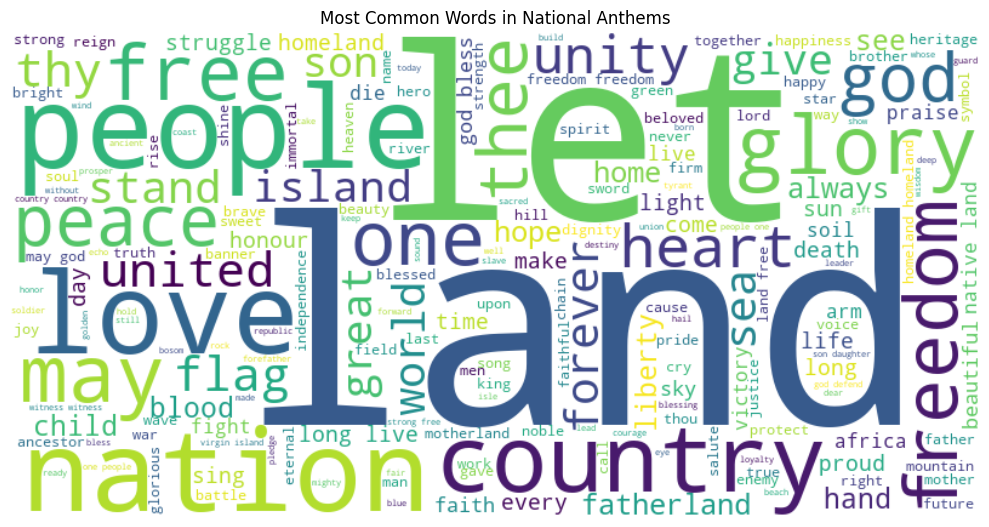


Anthem text clusters:
Cluster 0 (red): ax, bj, br, co, de...
Cluster 1 (blue): at, au, bl, bt, bz...
Cluster 2 (green): ae, ao, bf, bh, bo...
Cluster 3 (purple): ag, al, ar, bd, bm...
Cluster 4 (orange): ad, af, ai, am, anthems_translations_english.csv...


<Figure size 640x480 with 0 Axes>

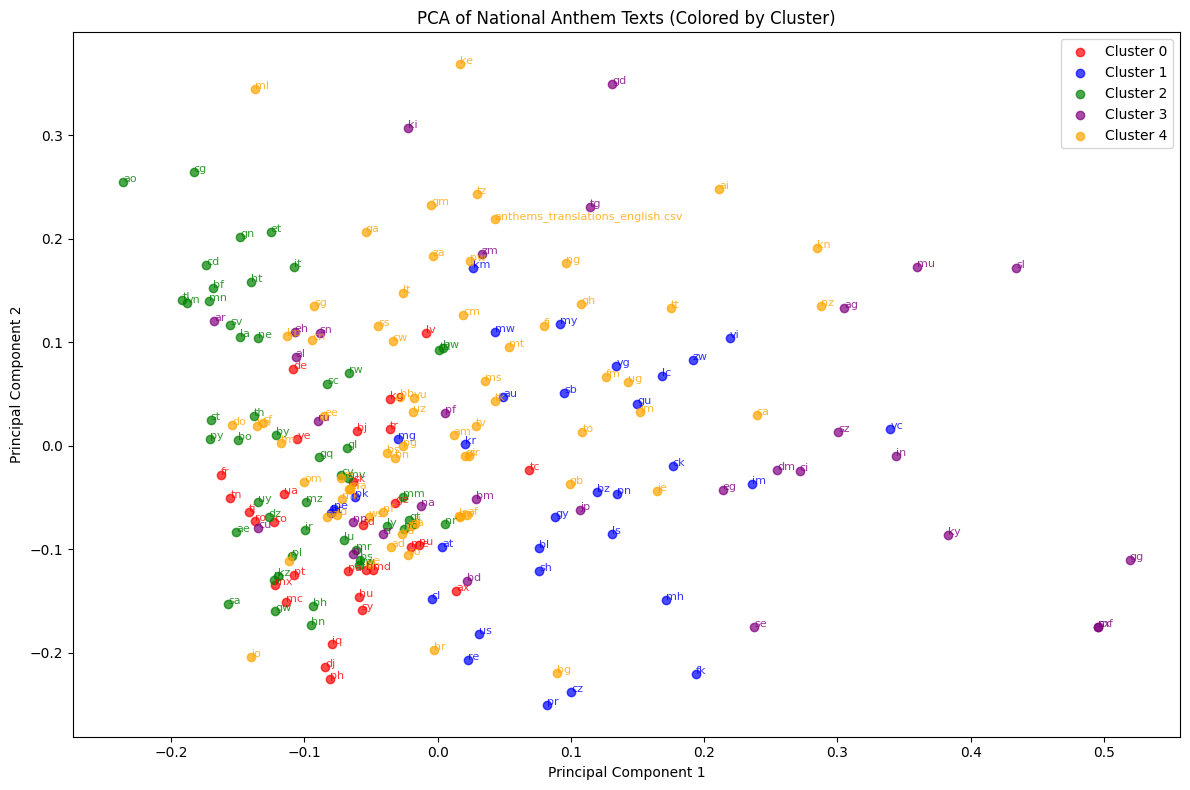

<Figure size 640x480 with 0 Axes>

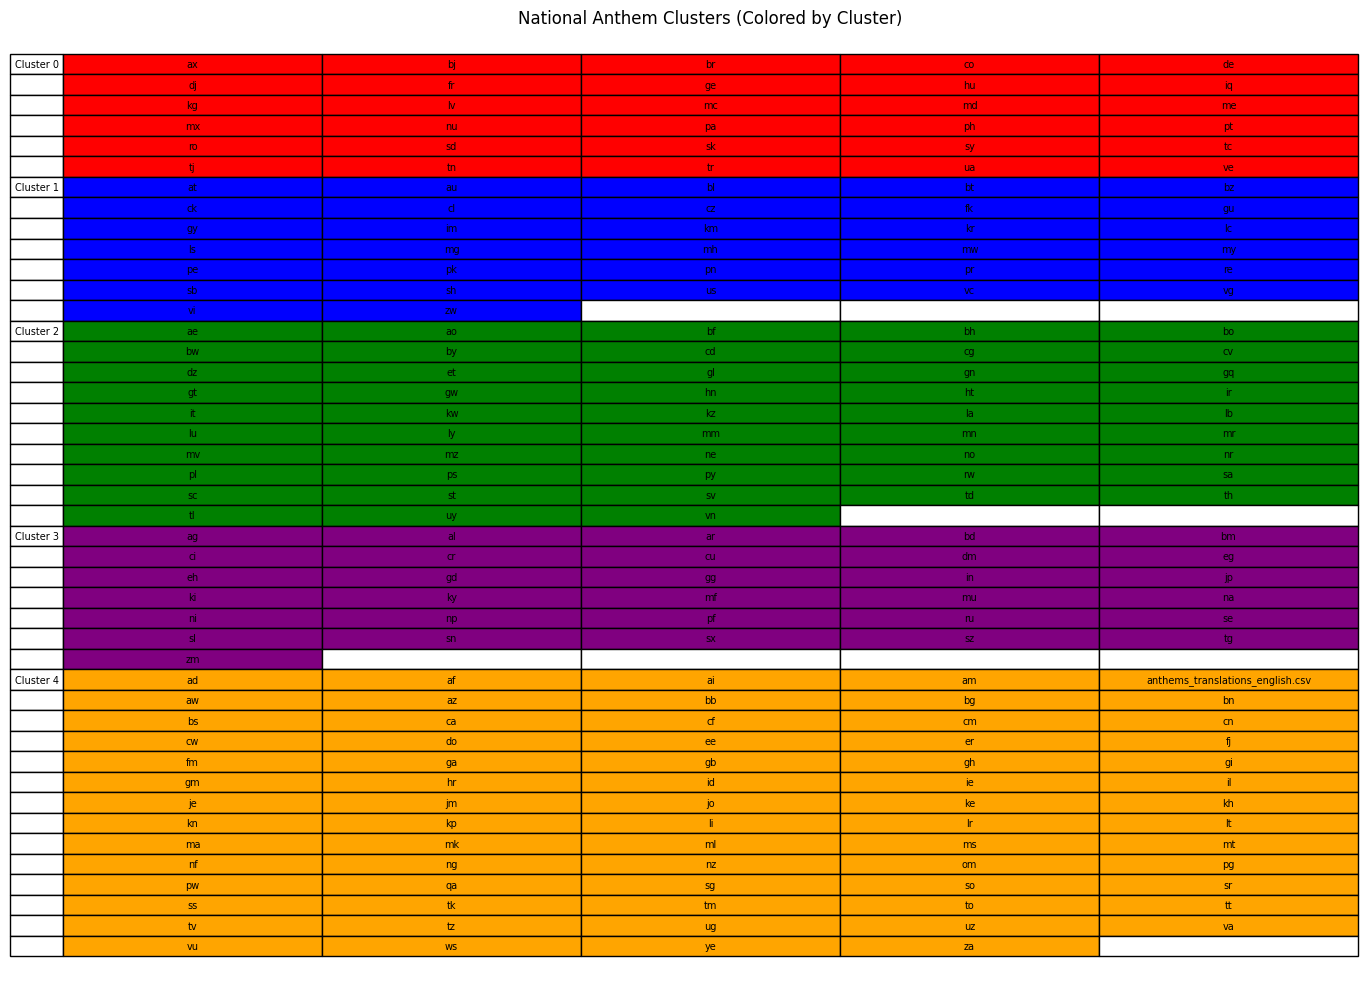


Top words for each topic:
Topic 0 (red): may, god, land, bless, protect, stand, almighty, peace, reign, free
Topic 1 (blue): thy, thee, thou, ever, beauty, martin, saint, blessing, green, coast
Topic 2 (green): country, glory, homeland, flag, live, long, land, time, sun, sky
Topic 3 (purple): let, people, one, fatherland, nation, freedom, united, unity, africa, happiness
Topic 4 (orange): island, home, sea, isle, far, love, shore, come, heart, see


<Figure size 640x480 with 0 Axes>

In [19]:
anthem_texts = load_anthem_texts()
processed_texts, tfidf_matrix, tfidf_df = analyze_anthem_texts(anthem_texts)
